# Numerical Analysis Project: Binary Logistic Regression

## Predicting Credit Card Default Risk

The goal of this project is to implement a **binary logistic regression model** using **Stochastic Gradient Descent (SGD)** to predict whether a client will **default on their credit card payment** in the upcoming month.

We use the **[Default of Credit Card Clients Dataset](https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset)**, which contains financial and demographic information for 30,000 credit card holders in Taiwan. Key features include:

- **LIMIT_BAL**: Amount of credit given
- **AGE**, **SEX**, **EDUCATION**, **MARRIAGE**
- **PAYMENT HISTORY** (PAY_0 to PAY_6)
- **BILL AMOUNTS** (BILL_AMT1 to BILL_AMT6)
- **PAST PAYMENTS** (PAY_AMT1 to PAY_AMT6)

The target variable is:

- `default.payment.next.month`  
  - **1** → the client defaulted on payment  
  - **0** → the client did not default

## Approach

The model is built from scratch using a custom binary classifier based on logistic regression, optimized through **Stochastic Gradient Descent**. The goal is to minimize the **logistic loss function** across training epochs:

$
\mathcal{L}(y, \hat{y}) = - \left[ y \cdot \log(\hat{y}) + (1 - y) \cdot \log(1 - \hat{y}) \right]
$

After training, the model is evaluated using key metrics such as **accuracy**, **precision**, **recall**, **f1-score**, and a **confusion matrix** is analyzed to understand how the model performs under class imbalance.

## Libraries Used

- `pandas` for data manipulation
- `numpy` for numerical operations
- `matplotlib` and `seaborn` for data visualization
- `scikit-learn` for preprocessing and evaluation metrics

---


In [1]:
# Standard library

# Third‑party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
np.random.seed(42)
# Set up graphics inside the Notebook
%matplotlib inline

In [2]:
# Dtaset URL
url = "https://raw.githubusercontent.com/Alex22sv/Alex22sv.github.io/refs/heads/main/UCI_Credit_Card.csv"

# Read dataset and use "," as separator
df = pd.read_csv(url, sep=',')

# Read the first rows of the table
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [3]:
# Revisar si hay valores nulos
print("\nNull values per column:")
print(df.isnull().sum())


Null values per column:
ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64


In [4]:
# Separate variables (X) and target (y)
X = df.drop(columns=["ID", "default.payment.next.month"])
y = df["default.payment.next.month"]

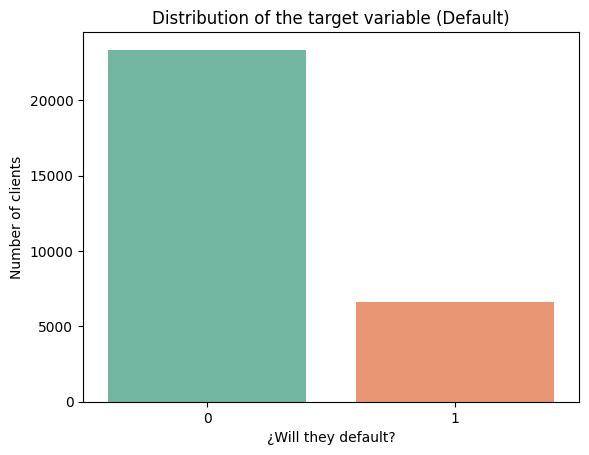

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

sns.countplot(x=y, hue=y, palette="Set2", legend=False)
plt.title("Distribution of the target variable (Default)")
plt.xlabel("¿Will they default?")
plt.ylabel("Number of clients")
plt.show()


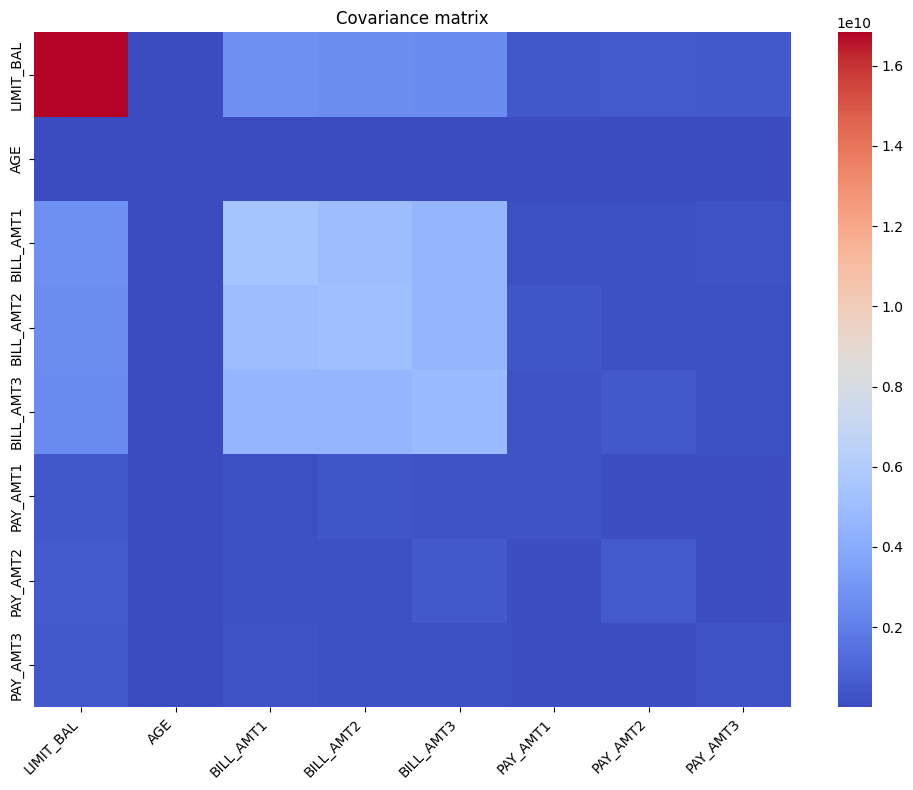

In [6]:
# Calcular y graficar la matriz de covarianza (sin incluir ID ni la variable objetivo)
features = [
    'LIMIT_BAL', 'AGE',
    'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
    'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3'
]

cov_matrix = df[features].cov()

plt.figure(figsize=(10, 8))
sns.heatmap(cov_matrix, annot=False, fmt='.2f', cmap='coolwarm')
plt.title("Covariance matrix")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [7]:
class LogisticRegressionSGD:
    def __init__(self, learning_rate=0.01, epochs=1000):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = 0
        self.loss_history = []

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def predict_proba(self, X):
        z = np.dot(X, self.weights) + self.bias
        return self.sigmoid(z)

    def predict(self, X, threshold=0.5):
        proba = self.predict_proba(X)
        return (proba >= threshold).astype(int)

    def compute_loss(self, y_true, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)

        for epoch in range(self.epochs):
            for i in range(n_samples):
                xi = X[i]
                yi = y[i]

                z = np.dot(xi, self.weights) + self.bias
                pred = self.sigmoid(z)

                error = pred - yi
                self.weights -= self.learning_rate * error * xi
                self.bias -= self.learning_rate * error

            # Calculate loss and save it
            y_preds = self.predict_proba(X)
            loss = self.compute_loss(y, y_preds)
            self.loss_history.append(loss)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = LogisticRegressionSGD(learning_rate=0.01, epochs=20)
model.fit(X_train, y_train.to_numpy())


In [9]:
y_pred = model.predict(X_test)

# Display metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:")
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.7978333333333333

Classification report:
              precision    recall  f1-score   support

           0       0.81      0.98      0.88      4687
           1       0.66      0.15      0.25      1313

    accuracy                           0.80      6000
   macro avg       0.73      0.57      0.57      6000
weighted avg       0.77      0.80      0.74      6000



**Metrics definitions:**
- **Precision**: of the times the model predicted a given class, how many were correct.
- **Recall**: of the actual instances of a class, how many did the model detect.
- **F1‑Score**: harmonic mean of precision and recall.
- **Support**: number of actual samples for each class.

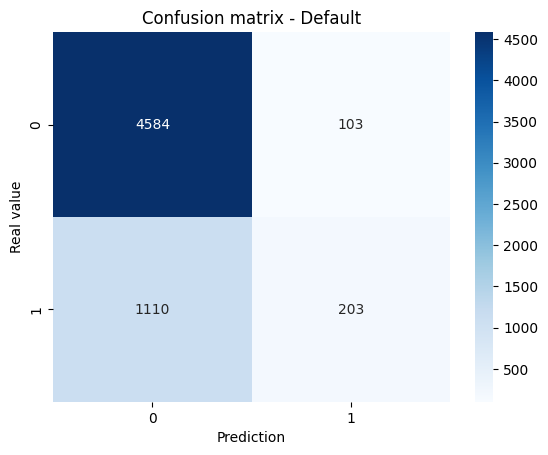

In [10]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Prediction")
plt.ylabel("Real value")
plt.title("Confusion matrix - Default")
plt.show()

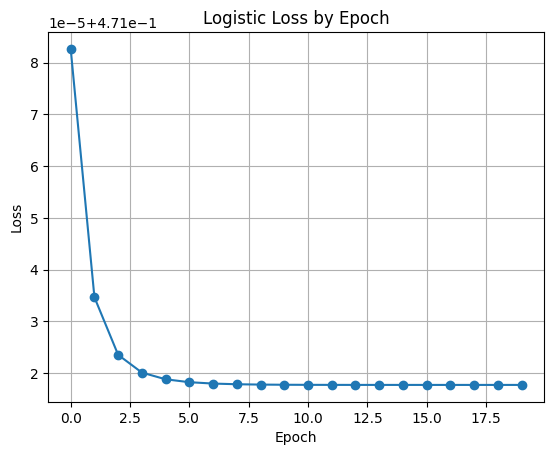

In [11]:
plt.plot(model.loss_history, marker='o')
plt.title("Logistic Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

## Conclusions

The final binary logistic regression model, trained from scratch using Stochastic Gradient Descent (SGD), reached an overall accuracy of **~80%** on the test dataset.

However, the analysis revealed that the model performs very well for class `0` (clients who did not default), but poorly on class `1` (clients who did default), with a recall of only **15%**.

This is caused by a **strong class imbalance** in the dataset: most clients do not default, so the model is biased toward predicting class `0`.

### Recommendations:
- Apply data balancing (oversampling or undersampling).
- Use weighted loss functions or adjust class weights.
- Test with additional epochs or learning rate tuning.

In summary, although the model is technically functional, it needs further adjustments to be reliable in detecting true default cases — which are the most relevant for real-world applications.
